# Document for Q3; Parts 2 and 3

### Import Necessary Tools

In [133]:
import data
from q3_1 import KNearestNeighbor

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, plot_roc_curve, auc

from joblib import dump, load

np.random.seed(1746)
fold_number = 10

### Helper Fucntion to Turn Vectors of Integers Into One Hot Vectors

In [134]:
def vector_to_one_hot(v):
    reshape_v = np.reshape(v, (-1,1))
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_v = one_hot_encoder.fit_transform(reshape_v)
    
    return one_hot_v

### Helper Function to Import the Data and Make the Lables One Hot

In [135]:
def import_data():
    train_data, train_labels, test_data, test_labels = data.load_all_data('data', shuffle=True)

    train_lables_one_hot = vector_to_one_hot(train_labels)
    test_lables_one_hot = vector_to_one_hot(test_labels)
    
    return train_data, train_labels, train_lables_one_hot, test_data, test_labels, test_lables_one_hot


### Helper Function to Cross Validate a Classfier

In [136]:
def cross_validate_clf(clf, train_data, train_labels):
    
    kf = KFold(n_splits=fold_number)
    i = 1
    model_accuracy = 0.0

    for train_index, validate_index in kf.split(train_data):
        print("\tRunning fold {}".format(i), end="*")
        i += 1

        fold_train_data = train_data[train_index]
        fold_train_label = train_labels[train_index]
        fold_validate_data =  train_data[validate_index]
        fold_validate_label = train_labels[validate_index]



        clf.fit(fold_train_data, fold_train_label)

        pred = clf.predict(fold_validate_data)

        fold_accuracy = accuracy_score(fold_validate_label, pred) * 100

        model_accuracy += fold_accuracy
        
    return model_accuracy / fold_number
    

### Helper Function to Draw Accuracy Score, Classification Report (Recall, Percision, Accuracy) and Confusion Matrix

In [137]:
def clf_performance(labels, predictions):
    
    print("Accuracy Score: {}".format(accuracy_score(labels, predictions) * 100))
    
    print("Classification Report: ")
    print(classification_report(labels,predictions, zero_division=1))
    
    print("Confusion Matrix: ")
    print(confusion_matrix(labels,predictions))
    

### Importing the Data

In [138]:
train_data, train_labels, train_lables_one_hot, test_data, test_labels, test_lables_one_hot = import_data()

print(train_data)
print(train_labels)


[[0.   0.   0.   ... 0.08 0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.53 0.83 0.78 ... 0.58 0.35 0.02]
 ...
 [0.64 0.68 0.43 ... 0.2  0.   0.  ]
 [0.42 0.67 0.64 ... 0.   0.   0.  ]
 [0.06 0.44 0.77 ... 0.77 0.61 0.16]]
[6. 3. 3. ... 0. 7. 1.]


## Part 2

### MLP Classifier

In [139]:
def choose_MLP_clf(train_data, train_lables_one_hot, layers_tuple=(32, 16, 8)):

    best_clf = None
    accuracy = 0.0
    

    for solver in ('lbfgs','adam','sgd'):
        for alpha in (1e-5, 5 * 1e-5, 1e-4, 5 * 1e-4):
            print("#Training with {} and alpha {}:".format(solver, alpha))
            
            clf = MLPClassifier(solver=solver, alpha=alpha, momentum=0.5,
                        hidden_layer_sizes=layers_tuple, random_state=1, max_iter=4000)
            
            model_accuracy = cross_validate_clf(clf, train_data, train_lables_one_hot)
            
            print("\n\t Model Accuracy: {}".format(model_accuracy))

            if(model_accuracy > accuracy):
                best_clf = clf
                accuracy = model_accuracy
                
    best_clf.fit(train_data, train_lables_one_hot)
    
    dump(best_clf, 'optimal_MLP.joblib')
    
    return best_clf


#### MLP chooser creates a files to persist the model We check if the file exists, or run the function

In [140]:
try:
    mlp_clf = load('optimal_MLP.joblib')
    print("loaded successfully")
except:
    mlp_clf = choose_MLP_clf(train_data, train_lables_one_hot)
    
mlp_clf.get_params()['solver']

mlp_pred_one_hot = mlp_clf.predict(test_data)
mlp_pred_int = pred_one_hot.argmax(axis=1)
        

loaded successfully


## SVM svc

In [141]:
def choose_SVM_clf(train_data, train_labels):

    best_clf = None
    accuracy = 0.0
    
    for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
        print("#Training with {}:".format(kernel))
        clf = SVC(kernel=kernel)
        
        model_accuracy = cross_validate_clf(clf, train_data, train_labels)

        print("\n\tAccuracy = {}".format(model_accuracy))

        if(model_accuracy > accuracy):
            best_clf = clf
            accuracy = model_accuracy
        
    best_clf.fit(train_data, train_labels)
    
    dump(best_clf, 'optimal_SVM.joblib')
    
    return best_clf


#### SVM chooser creates a files to persist the model We check if the file exists, or run the function

In [142]:
try:
    svm_clf = load('optimal_SVM.joblib')
    print("loaded successfully")
except:
    svm_clf = choose_SVM_clf(train_data, train_labels)
    
svm_clf.get_params()['kernel']

svm_pred_int = svm_clf.predict(test_data)
svm_pred_one_hot = vector_to_one_hot(svm_pred_int)

loaded successfully


## Adaboost

In [143]:
def choose_AdaBoost_clf(train_data, test_data):
    
    best_clf = None
    accuracy = 0.0
    
    n_estimators = np.arange(1, 15) * 100

    for n_est in n_estimators:
        
        print("Training with {} estimators".format(n_est))
        
        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=n_est,
                                 learning_rate=1)
        
        model_accuracy = cross_validate_clf(clf, train_data, train_labels)
            
        print("\n\tAccuracy = {}".format(model_accuracy))

        if(model_accuracy > accuracy):
            best_clf = clf
            accuracy = model_accuracy
        
    best_clf.fit(train_data, train_labels)
    
    dump(best_adaboost, 'optimal_adaboost.joblib')
    
    return best_clf
            

#### AdaBoost chooser creates a files to persist the model We check if the file exists, or run the function

In [144]:
try:
    adaboost_clf = load('optimal_adaboost.joblib')
    print("loaded successfully")
except:
    adaboost_clf = choose_AdaBoost_clf(train_data, test_data)
    
print(adaboost_clf.get_params()['n_estimators'])


adaboost_pred_int = adaboost.predict(test_data)
adaboost_pred_one_hot = vector_to_one_hot(adaboost_pred_int)

loaded successfully
1400


## Part 3

We have the predictions from MLP, SVM, and AdaBoost. 

We now predict the results with a KNN model from the previous part.

We already know that the best results come from K=1. We have:

In [145]:
knn = KNearestNeighbor(train_data, train_labels)

k = 1
knn_pred_int = knn.predict(k, test_data)
knn_pred_one_hot = vector_to_one_hot(knn_pred_int)

### Performance Report:

In [146]:
print("Performance Report for MLP:\n\n")
clf_performance(test_labels, mlp_pred_int)

print("\n\nPerformance Report for SVM:\n\n")
clf_performance(test_labels, svm_pred_int)

print("\n\nPerformance Report for AdaBoost:\n\n")
clf_performance(test_labels, adaboost_pred_int)

print("\n\nPerformance Report for KNN:\n\n")
clf_performance(test_labels, knn_pred_int)



Performance Report for MLP:


Accuracy Score: 80.975
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79       400
         1.0       0.89      0.97      0.93       400
         2.0       0.80      0.71      0.75       400
         3.0       0.76      0.81      0.79       400
         4.0       0.87      0.88      0.87       400
         5.0       0.82      0.79      0.80       400
         6.0       0.73      0.67      0.70       400
         7.0       0.93      0.79      0.85       400
         8.0       0.78      0.81      0.80       400
         9.0       0.86      0.76      0.81       400

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000

Confusion Matrix: 
[[363   0   5   0   0   8  15   0   9   0]
 [  0 388   2   1   2   0   1   1   5   0]
 [ 16   4 286   7   3   3  64   0  17   0]
 [  1   1  25 32

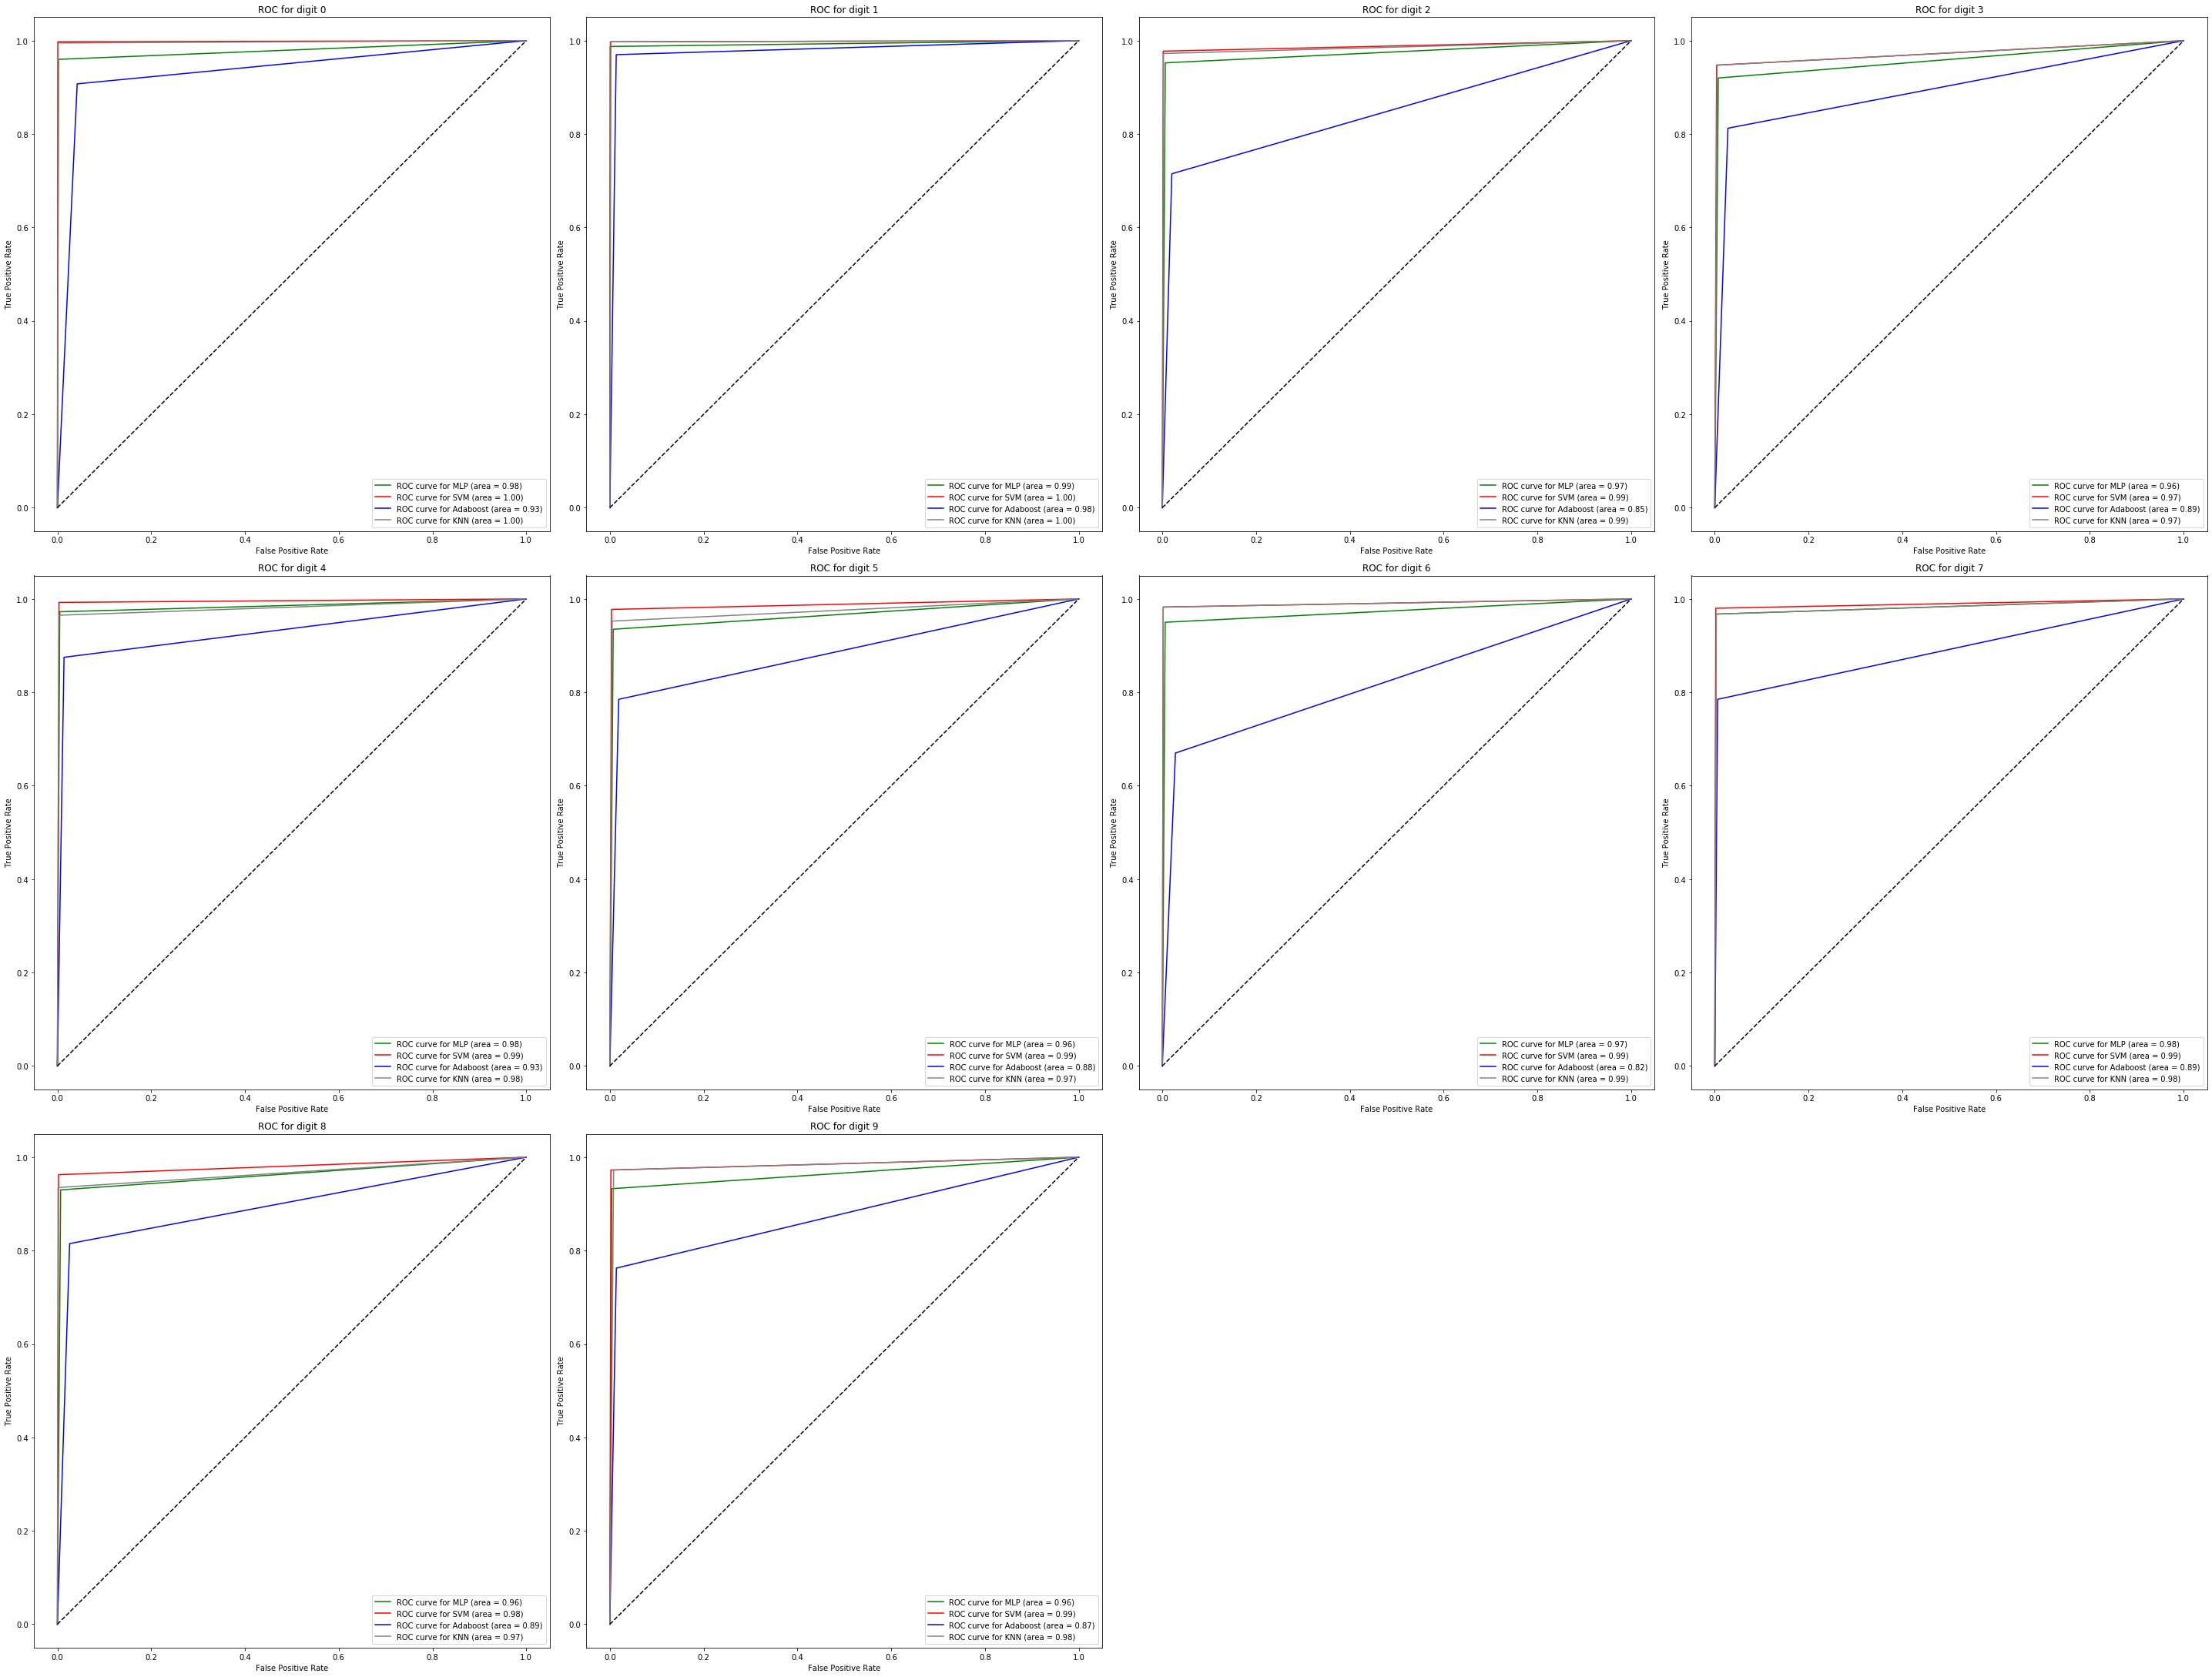

In [151]:
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()

fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

fpr_adaboost = dict()
tpr_adaboost = dict()
roc_auc_adaboost = dict()

fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()

n_classes = 10
for i in range(n_classes):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(test_lables_one_hot[:, i], mlp_pred_one_hot[:, i])
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])
    
    fpr_svm[i], tpr_svm[i], _ = roc_curve(test_lables_one_hot[:, i], svm_pred_one_hot[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])
    
    fpr_adaboost[i], tpr_adaboost[i], _ = roc_curve(test_lables_one_hot[:, i], adaboost_pred_one_hot[:, i])
    roc_auc_adaboost[i] = auc(fpr_adaboost[i], tpr_adaboost[i])
    
        
    fpr_knn[i], tpr_knn[i], _ = roc_curve(test_lables_one_hot[:, i], knn_pred_one_hot[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
    
    
plt.figure(figsize=(40, 40))

#data_features = df.columns[:-1]


# i: index
for i in range(0, 10):
    p = plt.subplot(4, 4, i + 1)
   # p.scatter(df[feature], df['TARGET'], s=0.22)

    p.plot(fpr_mlp[i], tpr_mlp[i], label='ROC curve for MLP (area = %0.2f)' % roc_auc_mlp[i], color='green')
    p.plot(fpr_svm[i], tpr_svm[i], label='ROC curve for SVM (area = %0.2f)' % roc_auc_svm[i], color='red')
    p.plot(fpr_adaboost[i], tpr_adaboost[i], label='ROC curve for Adaboost (area = %0.2f)' % roc_auc_adaboost[i], color='blue')
    p.plot(fpr_knn[i], tpr_knn[i], label='ROC curve for KNN (area = %0.2f)' % roc_auc_knn[i], color='grey')
    p.plot([0, 1], [0, 1], 'k--')
    p.legend(loc="lower right")
    p.set_xlabel('False Positive Rate')
    p.set_ylabel('True Positive Rate')
    p.set_title('ROC for digit {}'.format(i))
    
plt.tight_layout()
plt.show()
